In [16]:
import os
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from Bio import SeqIO
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.patches import Patch
import mpl_stylesheet
import re
import gc
mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 20, colors = 'banskt', dpi = 300)

In [17]:
# Load the data
import json
import collections

datadict = collections.defaultdict(dict)
for record in SeqIO.parse("disprot_OK_fullset.fasta", "fasta"):
    uniprot_id = record.id
    seq = str(record.seq)
    datadict[uniprot_id]['seq'] = seq

for record in SeqIO.parse("disprot_OK_fullset_annotations.fasta", "fasta"):
    uniprot_id = record.id
    seq = str(record.seq)
    datadict[uniprot_id]['disorder'] = seq

print(f"Loaded {len(datadict.keys())} proteins")

Loaded 2145 proteins


In [18]:
AA2num = dict(zip(sorted(list(set([i for i in datadict["P19793"]['seq']]))),np.arange(20)))
AA2num['</s>'] = 20
AA2num['X'] = 21
num2AA = dict(zip(np.arange(20),sorted(list(set([i for i in datadict["P19793"]['seq']])))))
num2AA[20] = "</s>"
num2AA[21] = "X"
AAsize = len(list(AA2num.keys()))

uniprots = list(datadict.keys())
delcounter = 0
for unip in uniprots:
    lossfile = f"loss/{unip}.json"
    if os.path.exists(lossfile):
        #print(unip)
        with open(lossfile) as instrm:
            lossdict = json.load(instrm)
        datadict[unip]["aamask_1"] = lossdict[unip]["aamask_1"]
    else:
        del(datadict[unip])
        delcounter += 1

print(f"Loaded {len(datadict.keys())} proteins")

Loaded 2145 proteins


In [19]:
## Obtains aa counts for order and disorder regions
order_aa_counts    = np.zeros(AAsize) 
disorder_aa_counts = np.zeros(AAsize)
for unip in datadict:
    seq = datadict[unip]['seq']
    diso_ix = [True if e != "-" else False for e in datadict[unip]['disorder'] ]
    for pos, aa in enumerate(seq):
        if aa not in AA2num:
            aa = "X"
        if diso_ix[pos]:
            disorder_aa_counts[AA2num[aa]] += 1
        else:
            order_aa_counts[AA2num[aa]] += 1

total_aa_counts = order_aa_counts + disorder_aa_counts
total_aa = np.sum(total_aa_counts)
total_ordered_aa = np.sum(order_aa_counts)
total_disordered_aa = np.sum(disorder_aa_counts)
labels = [num2AA[i] for i in range(len(order_aa_counts))]

print(total_aa)
print(total_ordered_aa)
print(total_disordered_aa)

827664.0
639673.0
187991.0


In [24]:
match_counts         = np.zeros(AAsize)     # nº of matches
mismatch_counts_aa   = np.zeros(AAsize)     # nº of total mismatches, could be more than 1 mismatch per masked aa
mismatch_in_disorder = np.zeros(AAsize)
mismatch_in_order    = np.zeros(AAsize)
match_in_disorder = np.zeros(AAsize)
match_in_order    = np.zeros(AAsize)
match_in_order_pos    = list()
match_in_disorder_pos = list()

mismatch_mask_counts = np.zeros(AAsize)     # nº of mismatches per masked aa, one count per masked embedding
mismatch_matrix             = np.zeros((AAsize,AAsize))
mismatch_matrix_in_disorder = np.zeros((AAsize,AAsize))
mismatch_matrix_in_order    = np.zeros((AAsize,AAsize))
mismatch_matrix_in_disorder_onsite = np.zeros((AAsize,AAsize))
mismatch_matrix_in_order_onsite    = np.zeros((AAsize,AAsize))
mismatch_posdiff = list()        # distance of the masked aa to the mismatched position (can separate long and short)
mismatch_posdiff_detail = list() # uniprot, masked aa pos, mismatch pos, prot length
n_pos_mismatch = collections.defaultdict(int) # nº of times a position was mismatched (on different masked aa)
n_mismatch_pos = collections.defaultdict(int) # nº of mismatches encountered for a single masked aa
loss_match    = list()
loss_mismatch = list()
loss_mismatch_in_order = list()
loss_mismatch_in_disorder = list()
onsm_offsmm = list() #on-site match but off-site mismatch
for unip in datadict:
    L = len(datadict[unip]['seq'])
    this_seq = datadict[unip]['seq']
    diso_ix = [True if e != "-" else False for e in datadict[unip]['disorder'] ]
    loss = np.array(datadict[unip]['aamask_1']['loss'])
    matches = datadict[unip]['aamask_1']['match']
    for pos,e in enumerate(matches):
        if e == True:
            match_counts[AA2num[this_seq[pos]]] += 1
            loss_match.append([loss[pos], L])
            if diso_ix[pos]: # in disordered region
                match_in_disorder[AA2num[this_seq[pos]]] += 1
                match_in_disorder_pos.append(f"{unip}_{pos}")
            else:
                match_in_order[AA2num[this_seq[pos]]] += 1
                match_in_order_pos.append(f"{unip}_{pos}")
        else:
            mismatch_mask_counts += 1
            loss_mismatch.append([loss[pos], L])
            n_mismatch_pos[f"{unip}_{pos}"] += len(e)
            this_pos_found = False
            for mismatch_aa in e:
                diff = mismatch_aa[0] - pos
                mismatch_posdiff.append(diff)
                mismatch_posdiff_detail.append([unip,pos,mismatch_aa[0],L])
                mismatch_counts_aa[AA2num[mismatch_aa[2]]] += 1
                n_pos_mismatch[f"{unip}_{mismatch_aa[0]}"] += 1
                mismatch_matrix[AA2num[mismatch_aa[2]],AA2num[mismatch_aa[1]]] += 1
                if diso_ix[mismatch_aa[0]]:
                    mismatch_matrix_in_disorder[AA2num[mismatch_aa[2]],AA2num[mismatch_aa[1]]] += 1
                    mismatch_in_disorder[AA2num[mismatch_aa[2]]] += 1
                    if pos == mismatch_aa[0]:
                        mismatch_matrix_in_disorder_onsite[AA2num[mismatch_aa[2]],AA2num[mismatch_aa[1]]] += 1
                        loss_mismatch_in_disorder.append(loss[pos]* L)
                        this_pos_found = True
                else:
                    mismatch_matrix_in_order[AA2num[mismatch_aa[2]],AA2num[mismatch_aa[1]]] += 1
                    mismatch_in_order[AA2num[mismatch_aa[2]]] += 1
                    if pos == mismatch_aa[0]:
                        loss_mismatch_in_order.append(loss[pos]* L)
                        mismatch_matrix_in_order_onsite[AA2num[mismatch_aa[2]],AA2num[mismatch_aa[1]]] += 1
                        this_pos_found = True
            if not this_pos_found:
                ## on-site match but off-site mismatch!! not very relevant if the mistmatch is +-1 or very close
                match_counts[AA2num[this_seq[pos]]] += 1
                if diso_ix[pos]:
                    match_in_disorder[AA2num[this_seq[pos]]] += 1
                else:
                    match_in_order[AA2num[this_seq[pos]]] += 1
                onsm_offsmm.append([unip,pos])

In [22]:
onsm_offsmm_disordered_match = np.zeros(AAsize)
onsm_offsmm_ordered_match = np.zeros(AAsize)
onsm_offsmm_disordered_pos = list()
onsm_offsmm_ordered_pos    = list()

for e in onsm_offsmm:
    unip = e[0]
    pos  = e[1]
    L = len(datadict[unip]['seq'])
    this_seq = datadict[unip]['seq']
    is_disordered = datadict[unip]['disorder'][pos] != "-"
    if is_disordered:
        onsm_offsmm_disordered_match[AA2num[this_seq[pos]]] += 1
        onsm_offsmm_disordered_pos.append(f"{unip}_{pos}")
    else:
        onsm_offsmm_ordered_match[AA2num[this_seq[pos]]] += 1
        onsm_offsmm_ordered_pos.append(f"{unip}_{pos}")

In [23]:
## save positions
allmatches_dict = dict()
allmatches_dict["match_in_order"] = match_in_order_pos
allmatches_dict["match_in_disorder"] = match_in_disorder_pos
allmatches_dict["onsm_offsmm_order"] = onsm_offsmm_ordered_pos
allmatches_dict["onsm_offsmm_disorder"] = onsm_offsmm_disordered_pos

with open("matches_positions_disprot.json", 'w') as outstream:
    json.dump(allmatches_dict, outstream)

In [13]:
# print(f"Matches in order: {np.sum(match_in_order)/np.sum(match_counts)}")
# print(f"Matches in disorder: {np.sum(match_in_disorder)/np.sum(match_counts)}")
## Above is wrong since it doesn't take into account the imbalance of order/disorder positions in the dataset
print(f"Matches in order: {np.sum(match_in_order)/total_ordered_aa}")
print(f"Matches in disorder: {np.sum(match_in_disorder)/total_disordered_aa}")
print(f"Ordered positions: {total_ordered_aa/total_aa}, Disordered positions: {total_disordered_aa/total_aa}")
print(f"on-site match in order but off-site mismatch : {np.sum(onsm_offsmm_ordered_match)/np.sum(match_counts)}")
print(f"on-site match in disorder but off-site mismatch: {np.sum(onsm_offsmm_disordered_match)/np.sum(match_counts)}")

Matches in order: 0.6733143340425498
Matches in disorder: 0.5367278220765888
Ordered positions: 0.7728655589707901, Disordered positions: 0.22713444102920993
on-site match in order but off-site mismatch : 0.19537585519967043
on-site match in disorder but off-site mismatch: 0.058184615905538174


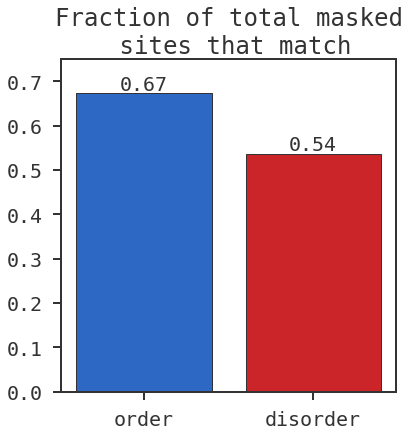

In [90]:

fig = plt.figure(figsize=(6,6), dpi=72)
ax1 = fig.add_subplot(111)
b = ax1.bar(x = np.arange(2), height = [np.sum(match_in_order)/total_ordered_aa, 0]) #, tick_label=["order", "disorder"])
b = ax1.bar(x = np.arange(2), height = [0, np.sum(match_in_disorder)/total_disordered_aa], tick_label=["order", "disorder"])

for bar in ax1.patches:
    if bar.get_height() > 0:
        ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.02,
                 format(bar.get_height(), '.2f'), 
                 ha='center', va='center')
ax1.set_ylim(0,0.75)
ax1.set_title("Fraction of total masked\n sites that match", ha='center')
plt.show()

In [92]:
#(np.sum(match_in_order)/total_ordered_aa) * (np.sum(onsm_offsmm_ordered_match)/np.sum(match_counts))
(np.sum(match_in_disorder)/total_disordered_aa) * (np.sum(onsm_offsmm_disordered_match)/np.sum(match_counts))

0.031229302173342348

In [14]:
assert (np.sum(match_in_order) + np.sum(match_in_disorder) ) == np.sum(match_counts)

In [15]:
print(np.sum(match_counts))
print(np.sum(match_in_order))
print(np.sum(match_in_disorder))
print(len(onsm_offsmm))

531601.0
430701.0
100900.0
134793


In [30]:
onsite_mismatches = [e for e in mismatch_posdiff_detail if e[1]==e[2]]
offsite_mismatches = [e for e in mismatch_posdiff_detail if e[1]!=e[2]]

mismatch_disorder_onsite = list()
mismatch_order_onsite    = list()
for e in onsite_mismatches:
    unip = e[0]
    pos  = e[1]
    this_seq = datadict[unip]['seq']
    is_disordered = datadict[unip]['disorder'][pos] != "-"
    if is_disordered:
        mismatch_disorder_onsite.append(f"{unip}_{pos}")
    else:
        mismatch_order_onsite.append(f"{unip}_{pos}")

allmismatches_dict = dict()
allmismatches_dict["mismatch_order_onsite"] = mismatch_order_onsite
allmismatches_dict["mismatch_disorder_onsite"] = mismatch_disorder_onsite

with open("mismatches_positions_disprot.json", 'w') as outstream:
    json.dump(allmismatches_dict, outstream)

In [98]:
# find for all onsite-matches, all the off-site mismatches with that site

# make this into a dict for faster search
onsm_offsmm_dict = collections.defaultdict(lambda: False)
for e in onsm_offsmm:
    onsm_offsmm_dict[f"{e[0]}_{e[1]}"] = True

tmp_dict = collections.defaultdict(list)
for om in offsite_mismatches:
    key = f"{om[0]}_{om[1]}"
    if onsm_offsmm_dict[key]:
        # if np.abs(om[1] - om[2]) > 1:
        tmp_dict[key].append(om)

onsm_offsmm_data_dict = collections.defaultdict(list)
for k in tmp_dict:
    unip = k.split("_")[0]
    onsm_offsmm_data_dict[unip] += tmp_dict[k]

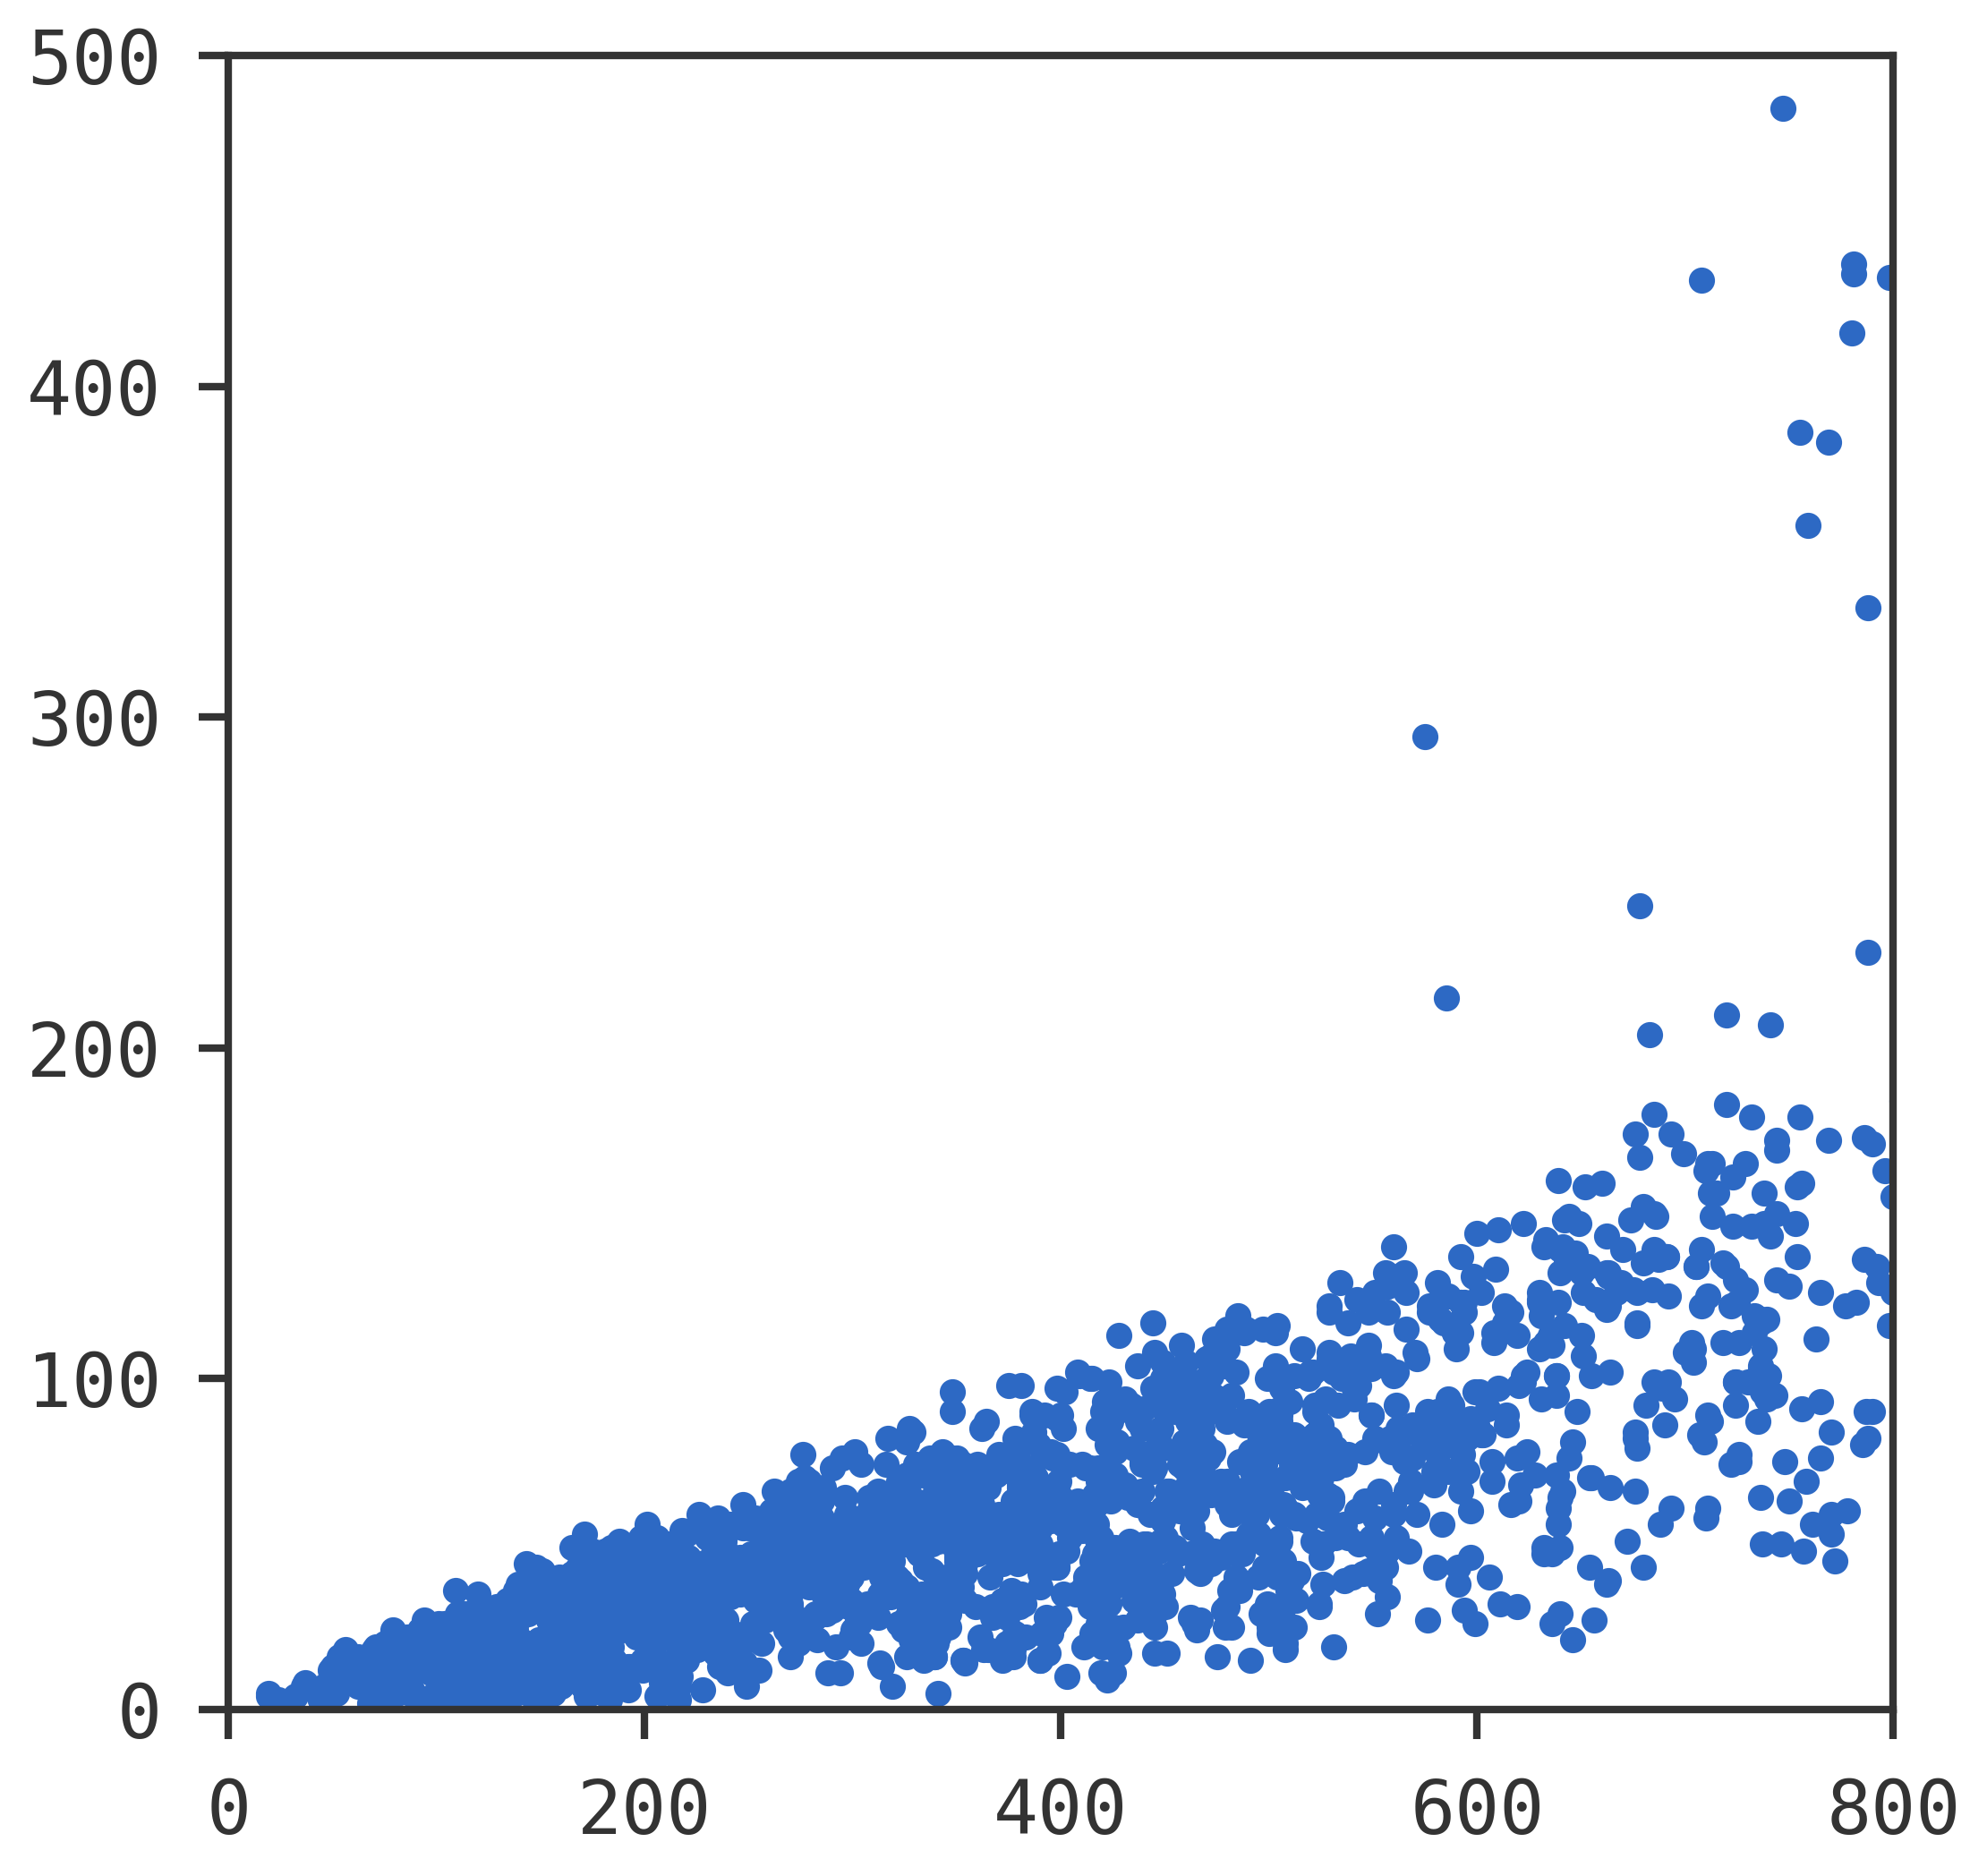

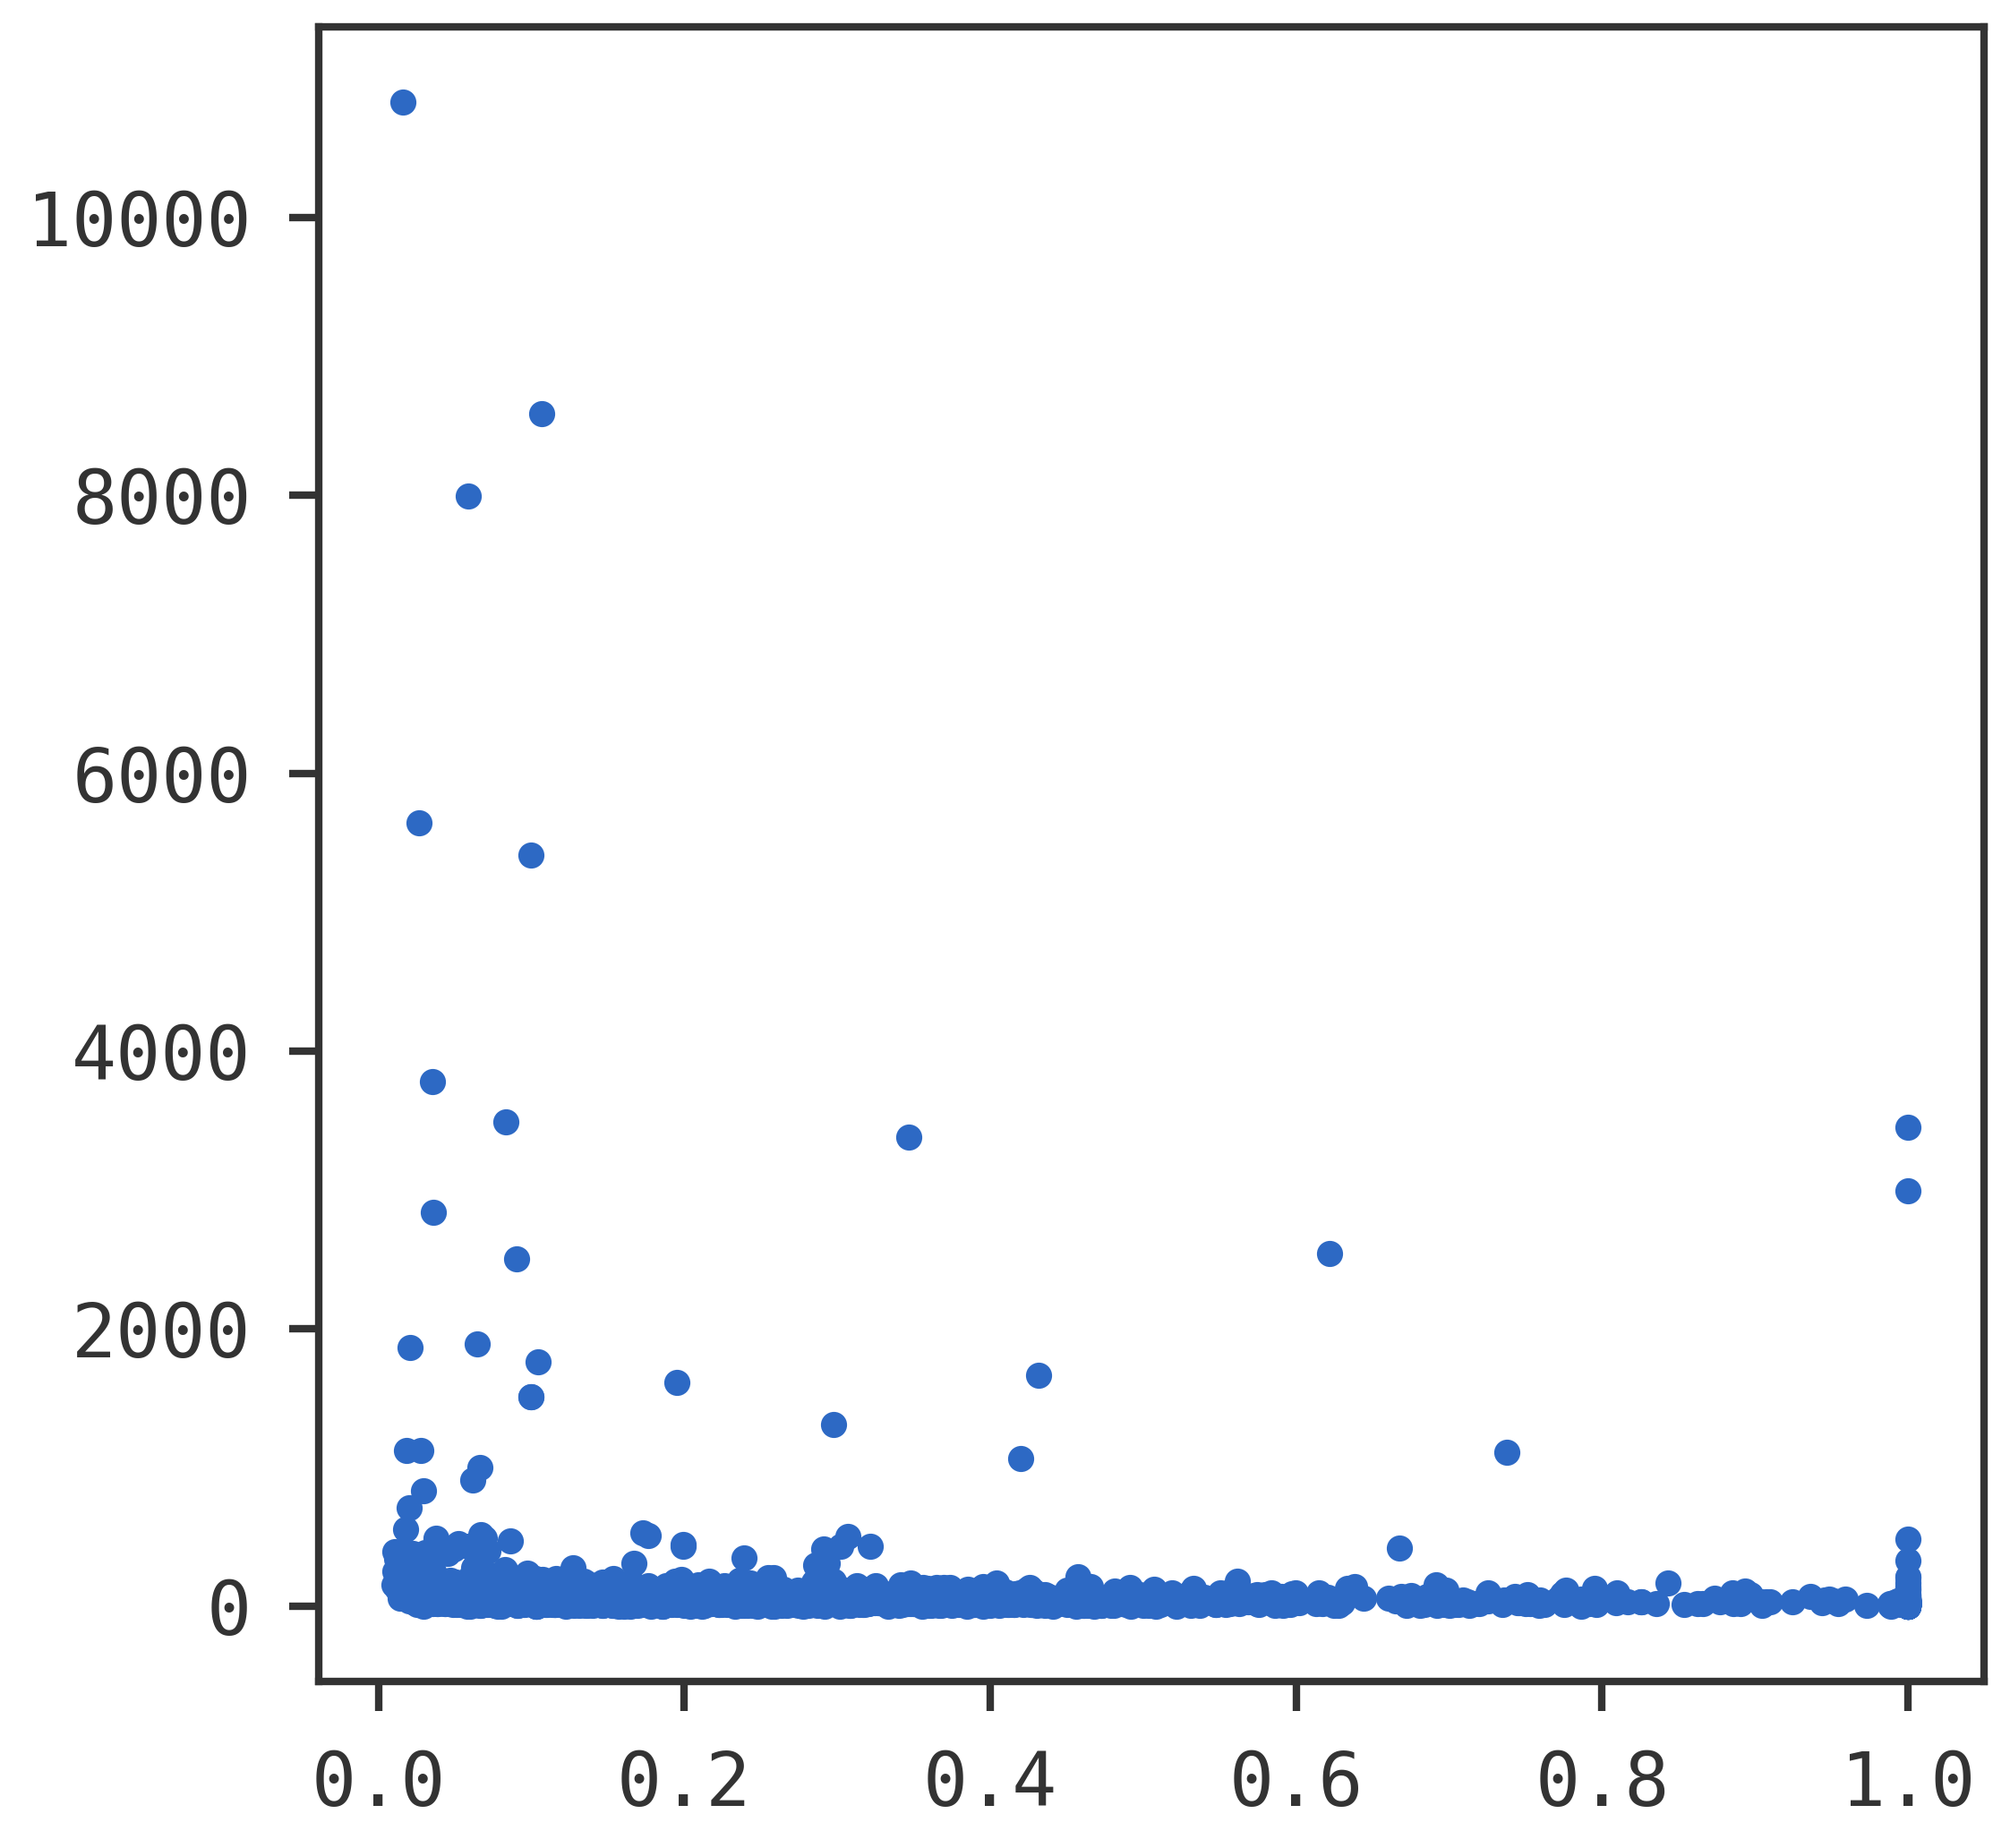

In [87]:
SEQLEN = list()
DC = list()
MM = list()
for unip in onsm_offsmm_data_dict:
    y = len(onsm_offsmm_data_dict[unip])
    seqlen = len(datadict[unip]['seq'])
    dc = np.sum([True if d != "-" else False for d in datadict[unip]['disorder']]) / seqlen
    #print(y, seqlen, dc)
    SEQLEN.append(seqlen)
    DC.append(dc)
    MM.append(y)

plt.scatter(SEQLEN, MM)
plt.xlim(0,800)
plt.ylim(0,500)
plt.show()

plt.scatter(DC, MM)

In [96]:
onsm_offsmm_data_dict

defaultdict(list,
            {'P03347': [['P03347', 28, 29, 512],
              ['P03347', 74, 75, 512],
              ['P03347', 92, 93, 512],
              ['P03347', 122, 123, 512],
              ['P03347', 136, 137, 512],
              ['P03347', 157, 158, 512],
              ['P03347', 213, 214, 512],
              ['P03347', 278, 279, 512],
              ['P03347', 348, 349, 512],
              ['P03347', 371, 372, 512],
              ['P03347', 373, 374, 512],
              ['P03347', 378, 379, 512],
              ['P03347', 382, 383, 512],
              ['P03347', 387, 388, 512],
              ['P03347', 399, 400, 512],
              ['P03347', 412, 413, 512],
              ['P03347', 439, 440, 512],
              ['P03347', 458, 459, 512],
              ['P03347', 469, 470, 512],
              ['P03347', 475, 476, 512],
              ['P03347', 477, 478, 512],
              ['P03347', 483, 484, 512],
              ['P03347', 497, 498, 512],
              ['P03347', 509, 510, 

In [101]:
acum  = 0
acum3 = 0
for unip in onsm_offsmm_data_dict.keys():
    local_mm = len(onsm_offsmm_data_dict[unip])
    local_mm3 = len([i for i in onsm_offsmm_data_dict[unip] if np.abs(i[1]-i[2]) > 3])
    acum += local_mm
    acum3 += local_mm3
    print(unip, local_mm)

print(f"Total off-site mismatches:{len(offsite_mismatches)}")
print(f"Total off-site mismatches with on-site match: {acum}")
print(f"Total off-site mismatches with on-site match with aa dist > 3: {acum3}")


P03347 25
P19793 28
P48439 74
P03265 63
P0CF51 30
P0ABJ3 29
P02511 12
Q9JIH2 76
Q5UPT2 77
Q15013 57
P78362 56
P63165 3
P08067 36
P09883 118
O43236 30
Q8IVH8 79
P0AES9 29
P49913 32
P04156 41
P28327 92
Q12142 299
P97784 40
P45523 37
O25010 13
P11409 63
Q9ERE3 68
B0FRH7 35
P02655 19
P01009 73
Q9UKX7 73
P10415 22
Q15726 22
P03496 38
P10636-2 37
P02259 42
Q14019 7
P12956 133
Q96SD1 99
P18615 62
P02315 13
P0AD27 89
P35269 71
P20893 16
P00488 179
P04083 66
Q14449 40
P12464 35
P28583 61
P63159 10
Q87P35 50
P0CU51 33
P02640 414
P47093 21
Q9NQA5 127
P61765 30
Q5T1C6 38
P52945 41
P05055 89
O00522 117
F1QR43 125
P24864 57
Q9GZN7 29
P14907 1112
P04147 120
Q10589 43
P04610 8
G5EFZ1 107
Q47184 35
Q9NQB0 31
P00734 147
P17870 26
P63241 7
P10175 16
P96884 63
E6PBU3 32
P04637 45
P00004 8
Q5SHN5 137
Q9JLC3 12
P58753 28
P01094 13
P0AFC3 33
Q39026 46
P00392 52
P45985 28
P27392 18
F2Z293 23
Q9UM11 29
P04968 41
O95149 53
O53168 101
P01100 65
P22531 8
P51177 36
A6NF83 17
P0A9A6 22
P0DTH5 72
P9WNK3 24
O32728 55

In [37]:
# relative diff of mismatch: diff / prot_length
order_to_order       = list() 
order_to_disorder    = list()
disorder_to_order    = list()
disorder_to_disorder = list()
for om in offsite_mismatches:
    rel_diff = (om[2] - om[1]) / om[3]
    annot_from = datadict[om[0]]['disorder'][om[1]]
    annot_to   = datadict[om[0]]['disorder'][om[2]]
    if annot_from != "-" and annot_to != "-":
        disorder_to_disorder.append((om,rel_diff))
    if annot_from != "-" and annot_to == "-":
        disorder_to_order.append((om,rel_diff))
    if annot_from == "-" and annot_to != "-":
        order_to_disorder.append((om,rel_diff))
    if annot_from == "-" and annot_to == "-":
        order_to_order.append((om,rel_diff))

print(f"O-O {len(order_to_order)}")
print(f"O-D {len(order_to_disorder)}")
print(f"D-O {len(disorder_to_order)}")
print(f"D-D {len(disorder_to_disorder)}")

O-O 340237
O-D 4295
D-O 5478
D-D 113465


In [93]:
order_to_order

[(['P03347', 28, 29, 512], 0.001953125),
 (['P03347', 74, 75, 512], 0.001953125),
 (['P03347', 92, 93, 512], 0.001953125),
 (['P03347', 122, 123, 512], 0.001953125),
 (['P03347', 136, 137, 512], 0.001953125),
 (['P03347', 157, 158, 512], 0.001953125),
 (['P03347', 213, 214, 512], 0.001953125),
 (['P03347', 278, 279, 512], 0.001953125),
 (['P03347', 348, 349, 512], 0.001953125),
 (['P03347', 371, 372, 512], 0.001953125),
 (['P03347', 373, 374, 512], 0.001953125),
 (['P03347', 399, 400, 512], 0.001953125),
 (['P03347', 412, 413, 512], 0.001953125),
 (['P03347', 458, 459, 512], 0.001953125),
 (['P03347', 469, 470, 512], 0.001953125),
 (['P03347', 475, 476, 512], 0.001953125),
 (['P03347', 477, 478, 512], 0.001953125),
 (['P03347', 483, 484, 512], 0.001953125),
 (['P03347', 497, 498, 512], 0.001953125),
 (['P03347', 509, 510, 512], 0.001953125),
 (['P03347', 510, 511, 512], 0.001953125),
 (['P19793', 133, 134, 462], 0.0021645021645021645),
 (['P19793', 232, 233, 462], 0.0021645021645021645

In [43]:

def filter_mismatches(lista):
    filtered1 = list()
    filtered2 = list()
    rel_dist_filt = list()
    prot_counts = collections.defaultdict(int)
    for e in lista:
        if (e[1] != 0) and (e[2] != 0):
            if np.abs(e[1]-e[2]) > 8:
                filtered1.append(e)
                prot_counts[e[0]] += 1
    for e in filtered1:
        if prot_counts[e[0]] > 3:
            filtered2.append(e)
            rel_dist_filt.append((e[2] - e[1]) / e[3])
    return filtered2, rel_dist_filt

o2o_filt, o2o_reldist_filt = filter_mismatches([e[0] for e in order_to_order])
o2d_filt, o2d_reldist_filt = filter_mismatches([e[0] for e in order_to_disorder])
d2o_filt, d2o_reldist_filt = filter_mismatches([e[0] for e in disorder_to_order])
d2d_filt, d2d_reldist_filt = filter_mismatches([e[0] for e in disorder_to_disorder])